In [101]:
import yfinance as yf
import numpy as np
import statistics
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
import warnings
import scipy.stats as stats
warnings.filterwarnings('ignore')
PATH_TO_STOCK = 'data/SSE50.csv'

1. Собрать данные по дневным ценам активов (акций) и дневным объемам продаж на заданном фондовом рынке за указанный период. Добавить (если нет) данные по индексу рынка

2. Преобразовать данные по ценам в данные по доходностям (используйте логарифмическую доходность). Вычислите оценки ожидаемых доходностей и стандартных отклонений и постройте «карту» активов в системе координат (σ, E).

3. Рассмотрите портфель с равными долями капитала и отметьте его на карте активов в системе координат (σ, E). Дайте характеристику этому портфелю.

4. Рассмотрите индекс рынка и отметьте его на карте активов в системе координат (σ,E). Дайте характеристику индексу рынка. PS σ - Risk, E - Expectation

In [2]:
def get_descriptive_statistics(frame):
    E = np.mean(frame["Log_R"])
    sigma = np.std(frame["Log_R"])
    frame['E'] = E
    frame['sigma'] = sigma
    return frame, E, sigma

def get_log_R(frame):
    frame['Log_R'] = np.log(frame['Close'] / frame['Close'].shift(1))
    return frame

In [3]:
stocks_stat = pd.DataFrame(columns=['sigma', 'E', 'names', 'mean_vol', 'mean_log_R', 'industry'])
stocks_info = pd.read_csv(PATH_TO_STOCK, names=['Name', 'Industry','Symbol'], delimiter=',')
n_stocks = len(stocks_info)
stocks = {}

for index, row in stocks_info.iterrows():
    name, industry, symbol = row
    if name != 'Index':
        symbol = str(symbol) + '.SS'
    stock = yf.download(symbol, start="2018-01-01", end="2018-12-31")
    stock = get_log_R(stock)
    stock, E, s = get_descriptive_statistics(stock)
    mean_vol = stock['Volume'].mean()
        
    stocks_stat.loc[index] = [s, E, name, mean_vol, stock['Log_R'].mean(), industry]
    stocks[str(industry)+'/'+str(name)] = stock

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [ ]:
fig = px.scatter(stocks_stat, x="sigma", y="E", hover_data=["names"], color="industry",title="E, Risk", size="mean_vol")

E_balanced = stocks_stat['E'].mean()
sigma_balanced = abs(np.sqrt(np.cov(stocks_stat['mean_log_R'])))
vol_balanced = stocks_stat['mean_vol'].mean()

fig.add_trace(go.Scatter(
    x=[sigma_balanced],
    y=[E_balanced],
    mode="markers+text",
    #name="index",
    text='Balanced portfolio',
    textposition="top center"
))
fig.add_trace(go.Scatter(
    x=stocks_stat[stocks_stat.names == 'Index']['sigma'].values,
    y=stocks_stat[stocks_stat.names == 'Index']['E'].values,
    mode="markers+text",
    #name="index",
    text='Index SSE50',
    textposition="top center"
))
fig.show()
pio.write_html(fig, file='report/fig1.html', auto_open=True)

### Задание 3-4 (Характеристика индекса рынка  сбалансированного портфеля)

- Индекс рынка SSE50 - индекс топ-50 компаний Shanghai Stock Exchange, отобранных по "отрегулированной" (float-adjusted) капитализации и другим признакам. На графике (fig1.htaml) можно заметить, что индекс (точка Index SSE50) находится в зоне наибольшей концентрации активов ($\sigma [0.01, 0.02], E [-0.0015, 0]$) и тем самым отражает поведение наиболее значимых активов рынка (рамер точки - средний объём продаж за 2018 год), которые принадлежат банкам (см. легенду графика).

- Сбалансированный портфель представляет собой равнодолевой портфель из всех активов индекса SSE50. Стоит отметить, что равнодолевой портфель с успехом деверсифицирует риск акций SSE50 и вложение в него более выгодно, чем в индекс рынка. Для объяснения этого предположения обратимся к определению индекса SSE50: "SSE 50 Index is the stock index of Shanghai Stock Exchange, representing the top 50 companies by "float-adjusted" capitalization and other criteria. In order to qualify as a constituent of SSE 50 Index, it must be a constituent of SSE 180 Index, thus SSE 50 is a subindex of SSE 180 Index."(Wiki). Т.е веса, которые даны активам в SSE50, которые должны отражать тенденции SSE180 и всего SSE нацелены на отражение тенденций, что и показано на графике. Если же мы рассматриваем целесообразность инвестиций, то для нас больший интерес представляет равнодолевой портфель, т.к он находится на одном уровне доходности с индексом SSE50, но имеет практически минимальный риск.



### 6. Выберите несколько интересных (значимых) активов рынка. Можно ли считать наблюдаемые доходности (объемы продаж) конкретного актива повторной выборкой из некоторого распределения (белый шум)? Поищите научные подходы к ответу на этот вопрос (проверка гипотезы о случайности, Ивченко Г.И. Медведев Ю.И. Введение в математическую статистику)

#### **Гипотеза о случайности.**
В различных статистических задачах исходные данные $X = (X_1, ..., X_n)$ часто рассматривают случайную выборку из некоторого распределения $\beta(\sigma)$, то есть считают компоненты  $X_i$ вектора данных $X$ независимыми и одинаково распредленными случайными величинами. Это исходное предположение нуждается в проверке как специальная статистическая гипотеза. Такая гипотеза называется **гипотезой случайности** и записывается в виде: $H_0 -    F_X(x_1,...,x_n) = F(x_1), ..., F(x_n)$, где $F(x)$ - некоторая одномерная функция распределения.                                                 


In [87]:
stocks_names = ['Banking/Bank of Jiangsu', 
                'Automotive/SAIC Motor', 
                'Construction/China Railway Construction ', 
                'Oil & gas/PetroChina',
                'Telecommunication/China United Network Communications']

### Критерий инверсий

Инверсия имеет место, если в выборке значений $x_1,...,x_n$ записанных в порядке их появления, за некоторым значением  $x_i$ следует меньшее по величине, т.е. $x_i > x_j$, где $i<j<=n$. Статистикой критерия случайности является общеечисло инверсий $I$ в выборке $x_1,...,x_n$

Гипотеза о случайности не отклоняется, если $I_\alpha < I < I_1-\alpha/2$. Возможное количество инверсий зависит от объема выборки. Математическое ожидание и дисперсия статистики $I$ имеют вид $E[I] = \frac {n(n-1)}{4}$, $D[I] = \frac{(2n^3 + 3n^2 - 5n)}{72}$

Нормализованная статистика: $I^* = \frac{I - E[I]}{sqrt(D[I])}$ 

Гипотеза $H_0$ отклоняется при больших по модулю значениях статистики $|I^*| >= U_1-\alpha/2$

In [42]:
def drop_nan_values(stock):
    return stock[~numpy.isnan(stock)]

In [88]:
def mergeSort(arr, n): 
    temp_arr = [0]*n 
    return _mergeSort(arr, temp_arr, 0, n-1) 

In [13]:
def _mergeSort(arr, temp_arr, left, right): 
    inv_count = 0
    if left < right:
        # Делим массив на подмассивы 
        mid = (left + right)//2
  
        # Количество инверсий в левом подмассиве 
  
        inv_count += _mergeSort(arr, temp_arr, left, mid) 
  
        # Количество инверсий в правом подмассиве 
  
        inv_count += _mergeSort(arr, temp_arr, mid + 1, right) 
  
        # Мерджим массивы и сортируем их
  
        inv_count += merge(arr, temp_arr, left, mid, right) 
    return inv_count

In [51]:
def merge(arr, temp_arr, left, mid, right): 
    i = left    
    j = mid + 1 
    k = left     
    inv_count = 0
    while i <= mid and j <= right: 
        if arr[i] <= arr[j]: 
            temp_arr[k] = arr[i] 
            k += 1
            i += 1
        else: 
            # Инверсия
            temp_arr[k] = arr[j] 
            inv_count += (mid-i + 1) 
            k += 1
            j += 1
    while i <= mid: 
        temp_arr[k] = arr[i] 
        k += 1
        i += 1
    while j <= right: 
        temp_arr[k] = arr[j] 
        k += 1
        j += 1
    for loop_var in range(left, right + 1): 
        arr[loop_var] = temp_arr[loop_var] 
          
    return inv_count 

In [102]:
def inversion_test(stock, alpha, label):
    cleaned_stock = drop_nan_values(stock[label])
    n = len(cleaned_stock)
    inv_amount = mergeSort(cleaned_stock, n) # число инверсий в данных, инверсия - когда i < j , а arr[i] > arr[j]
    inv_amount_expectation = (n*(n-1)) / 4
    inv_amount_variance = (n*(n-1)*(2*n+5)) / 72
    normalized_inv_statistic = (inv_amount - inv_amount_expectation)/(inv_amount_variance**(1/2))
    return abs(normalized_inv_statistic) >= stats.norm.ppf(1 - alpha/2)
    
    

In [103]:
start = "\033[1m"
end = "\033[0;0m"
alpha = 0.05
for label in stocks_names:
    stock = stocks[label]
    for column in ['Log_R','Volume']:
        if inversion_test(stock, alpha, column):
            print(f'Гипотеза случайности для {start}{label}{end}: {column} отвергается по критерию инверсий')
        else:
            print(f'Гипотеза случайности для {start}{label}{end}:{column} принимается  по критерию инверсий')
        

Гипотеза случайности для Banking/Bank of Jiangsu:Log_R принимается  по критерию инверсий
Гипотеза случайности для Banking/Bank of Jiangsu: Volume отвергается по критерию инверсий
Гипотеза случайности для Automotive/SAIC Motor:Log_R принимается  по критерию инверсий
Гипотеза случайности для Automotive/SAIC Motor: Volume отвергается по критерию инверсий
Гипотеза случайности для Construction/China Railway Construction :Log_R принимается  по критерию инверсий
Гипотеза случайности для Construction/China Railway Construction : Volume отвергается по критерию инверсий
Гипотеза случайности для Oil & gas/PetroChina:Log_R принимается  по критерию инверсий
Гипотеза случайности для Oil & gas/PetroChina: Volume отвергается по критерию инверсий
Гипотеза случайности для Telecommunication/China United Network Communications:Log_R принимается  по критерию инверсий
Гипотеза случайности для Telecommunication/China United Network Communications: Volume отвергается по критерию инверсий


### 7. Выберите несколько интересных (значимых) активов рынка из разных производственных секторов. В предположении, что наблюдаемые доходности (объемы продаж) являются повторной выборкой из некоторого распределения исследовать (выборочно) распределения доходностей и объемов продаж выбранных активов. Сделать выводы.

In [21]:
from scipy.stats import norm
stocks_names = ['Banking/Bank of Jiangsu', 
                'Automotive/SAIC Motor', 
                'Construction/China Railway Construction ', 
                'Oil & gas/PetroChina',
                'Telecommunication/China United Network Communications']
def plot_R_vs_Norm_distribution(label):
    stock = stocks[label]
    stock['Log_R'].hist(bins=30, histtype="stepfilled",alpha=0.5)
    E = stock['E'].values[0]
    sigma = stock['sigma'].values[0]
    x = np.linspace(E - 3*sigma, E+3*sigma,100)
    plt.plot(x, scipy.stats.norm.pdf(x, E, sigma), "r")
    plt.title("{} returns ({} industry) vs. normal distribution".format(label.split('/')[1], label.split('/')[0]))
    plt.show()

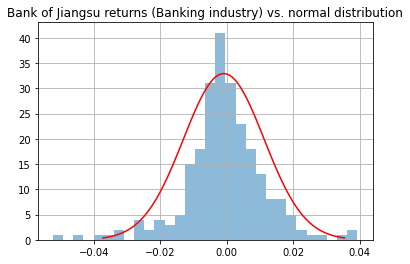

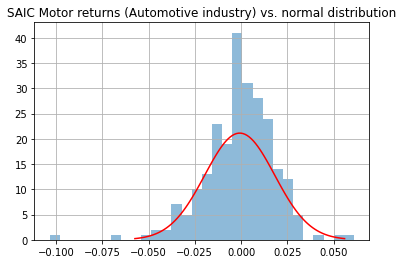

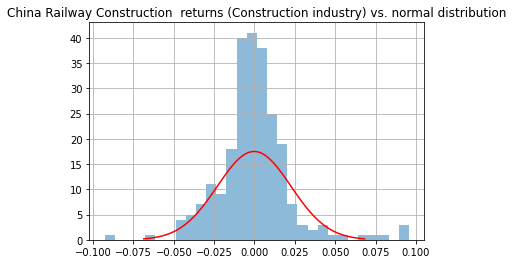

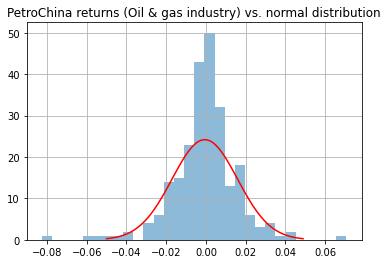

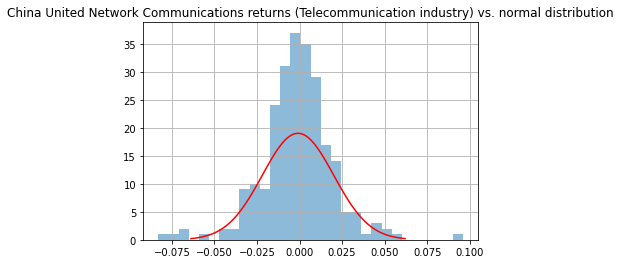

In [99]:
for label in stocks_names:
    plot_R_vs_Norm_distribution(label)



### **Тест Шапиро-Уилка**

Нулевая гипотеза $H_0$ теста Шапиро–Уилка заключается в том, что случайная величина, выборка $x$ которой известна, распределена по нормальному закону. Альтернативная гипотеза $H_1$ заключается в том, закон распределения не является нормальным.


In [104]:
n = 0 # номер элемента в списке подвыборки актива
x = stocks[stocks_names[n]]['Log_R'] # 'Banking/Bank of Jiangsu
shapiro_test = stats.shapiro(x[1:])

print("Shapiro test p_value: {:.10f}".format(shapiro_test[1]))

Shapiro test p_value: 0.0000003545




Вот здесь несостыковка, получается, что актив имеет не нормальное распределение при адекватных уронях занчимости ($p-value &lt; \alpha$) и гипотезу $H_0$ нужно отвергнуть

И для остальных активов из $stocks-names$ такая же ситуация, поэтому не понятно насколько целесообразно предполагать, что у них доходности имеют нормальное распределение. Если - это не целесообразно, то рассуждения ниже имеют ли смысл?



### **t-тест Стьюдента**

Одновыборочный t-тест предназначен для проверки равенства математического ожидания нормально распределенной случайной величины (для которой известна лишь выборка) некоторому заданному значению в предположении, что дисперсия не известна.


In [105]:
true_mu = 0
n = 1
x = stocks[stocks_names[n]]['Log_R'] # 'Automotive/SAIC Motor'
onesample_results = scipy.stats.ttest_1samp(x, true_mu, nan_policy='omit')
print("Onesample t-test p_value: {:.10f}".format(onesample_results[1]))

Onesample t-test p_value: 0.5527819825



### **Двухвыборочный тест Стьюдента**

служит для сравнения математических ожиданий нормально распределенных случайных величин в предположении, что их дисперсии равны, хотя и не известны. Таким образом, нулевая гипотеза формулируется как $«E(X) = µ»$ или $«E(X) − E(Y ) = µ»$.

Гипотеза $H_0$: Индекс SSE50 и актив 'SAIC Motor' из индустрии 'Automotive' нормально распределены и их мат. ожидания равны ($µ = 0$)


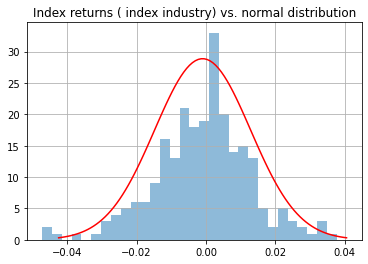

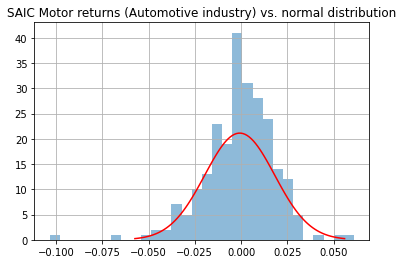

In [107]:
for label in [' index/Index', stocks_names[n]]:
    plot_R_vs_Norm_distribution(label)

In [108]:


index = stocks[' index/Index']['Log_R']
x = stocks[stocks_names[n]]['Log_R']
twosample_results = scipy.stats.ttest_ind(x, index,
                                          nan_policy='omit')
print("Twosample t-test p_value: {:.10f}".format(twosample_results[1]))



Twosample t-test p_value: 0.8633304174



При уровне значимости, например, $\alpha = 0.05$ можем принять гипотезу 